# Let's explore the RFX MDSplus tree

## Importing and setting up stuff

In [ ]:
import MDSplus as mds
import numpy as np
import matplotlib.pyplot as plt
import sys, random
from tqdm import tqdm
print(f'Python version: {sys.version}')
print(f'MDSplus version: {mds.__version__}')
np.set_printoptions(precision=3, suppress=True)

In [ ]:
#color the terminal output
def pick_random_color():
    return '\033[38;5;{}m'.format(random.randint(8, 230))
ENDC = '\033[0m'
ERR = '\033[91m'+ 'ERR: '
OK = '\033[92m' 
WARN = '\033[93m'+ 'WARN: '

In [ ]:
# define the shot number and tree
SHOT = 30810
rfx = mds.Tree('rfx', SHOT, 'readonly') # open the tree read-only
from convert_to_hdf5 import SEG_FAULT_NODES

## Traversing the tree

In [ ]:
# traverse the tree, use MAX_DEPTH to limit the depth of the tree to traverse
# othwerwise the script will run for about 10 minutes
MAX_DEPTH = 3# 13 # maximum depth of the tree to traverse
COLORS = [pick_random_color() for _ in range(MAX_DEPTH)]

In [ ]:
usage_depth, usage_breadth = {},{}
total_nodes_depth, total_nodes_breadth = [],[]

def traverse_tree_depth_first(max_depth, node, level=0, path='', node_type='child'):
    try: 
        if level >= max_depth: return # stop if the maximum depth is reached
        if node.getFullPath() in SEG_FAULT_NODES: return # skip the nodes that cause segfault
        if node_type == 'child': node_name = node.node_name.upper()
        elif node_type == 'member': node_name = node.node_name.lower()
        else: raise
        path = path + '/' + COLORS[level] + node_name + ENDC # add the node name
        total_nodes_depth.append(node) # add the node to the list
        print(f'{path}:{node.decompile()}') 
        # get the usage/type of the node
        try: usage_depth[str(node.usage)] += 1
        except: usage_depth[str(node.usage)] = 1
        # go through the children and members of the node
        for child in node.getChildren(): # get the children of the node
            traverse_tree_depth_first(max_depth, child, level + 1, path, 'child')
        for member in node.getMembers(): # get the members of the node
            traverse_tree_depth_first(max_depth, member, level + 1, path, 'member')
    except Exception as e:
        print(path + 'ERR:' + str(e))
        pass

# do the same but without recursion
def traverse_tree_breadth_first(max_depth, head_node):
    curr_nodes = [head_node]
    for d in range(max_depth):
        print('Depth:', d)
        next_nodes = []
        for node in curr_nodes:
            try:
                if node.getFullPath() in SEG_FAULT_NODES: continue # skip the nodes that cause segfault
                preprint = COLORS[d] + "   " * d + node.node_name + ENDC
                print(f'{preprint}:{node.decompile()}') # print the node
                total_nodes_breadth.append(node) # add the node to the list
                # get the usage/type of the node
                try: usage_breadth[str(node.usage)] += 1
                except: usage_breadth[str(node.usage)] = 1
                # get the children of the node
                for child in node.getChildren():
                    next_nodes.append(child)
                # get the members of the node
                for member in node.getMembers():
                    next_nodes.append(member)
            except: pass
        curr_nodes = next_nodes
        
# get the top node of the tree
head_node = rfx.getNode('\\TOP.RFX.MHD') # get the top node
# # test the functions, uncomment to run
traverse_tree_depth_first(MAX_DEPTH, head_node) # traverse the tree depth-first
traverse_tree_breadth_first(MAX_DEPTH, head_node) # traverse the tree breadth-first

print(f'Total nodes depth: {len(total_nodes_depth)}') # 96771, 96750
print(f'Total nodes breadth: {len(total_nodes_breadth)}') # 96771, 96750

In [ ]:
print(f'Usage depth: {usage_depth}')
print(f'Usage breadth: {usage_breadth}')

previous cell full depth: 'STRUCTURE': 8776, 'SUBTREE': 78, 'DEVICE': 642, 'ACTION': 1098, 'NUMERIC': 47760, 'TEXT': 17269, 'SIGNAL': 20904, 'ANY': 29, 'AXIS': 215

In [ ]:
print(f'top nodes: {[n.node_name for n in head_node.getChildren()]}')

## Exploring Signals

In [ ]:
search_space = '\\TOP.RFX.MHD.***' # *** means all nodes at this level
# search_space = '\\TOP.RFX.EDA.***' # * means all nodes at this level
# search_space = '\\TOP.RFX.***' # whole rfx tree
signal_nodes = rfx.getNodeWild(search_space, 'Signal') # get all nodes with the name 'Signal'
print(f'Found {len(signal_nodes)} of the type Signal in the search space {search_space}')

In [ ]:
# filter out the nodes without the data
data_signals = []
for node in tqdm(signal_nodes, leave=False):
    try: data = node.data(); data_signals.append(node)
    except: pass
print(f'Found {len(data_signals)}/{len(signal_nodes)} signals with data')

In [ ]:
# keep only the signals with raw data
raw_signals = []
for node in tqdm(signal_nodes, leave=False):
    try: data = node.raw_of().data(); raw_signals.append(node)
    except: pass
print(f'Found {len(raw_signals)}/{len(data_signals)} signals with raw data')

In [ ]:
# extract data from the signals and plot them
MAX_LOAD = 3 #10 #np.inf
MAX_LOAD = min(MAX_LOAD, len(raw_signals))
# select MAX_LOAD random signals
signals = random.sample(raw_signals, MAX_LOAD)
for node in (signals):
    signal = node.data()
    times = node.dim_of().data()
    unit = node.getUnits()
    full_path = node.getFullPath()
    try: node_help = node.getHelp()
    except: node_help = ''
    if signal.shape != times.shape:
        print(f'{full_path} has mismatched signal and time shapes')
        continue
    # plot the signal
    plt.figure()
    plt.plot(times, signal)
    plt.title(f'{full_path} [{unit}]\n{node_help}')
    plt.xlabel('Time [s]')
    plt.ylabel('Signal')
    plt.show()

## Exploring Text

In [ ]:
text_nodes = rfx.getNodeWild(search_space, 'Text') # get all the 'TEXT' nodes
print(f'Found {len(text_nodes)} of the type Text in the search space {search_space}')
# print all the text nodes
for node in text_nodes:
    try: print(f'{node.getFullPath()}={node.data()}')
    except: pass

## Exploring Times

In [ ]:
import MDSplus as mds
import numpy as np
import sys
from tqdm import tqdm
print(f'Python version: {sys.version}')
print(f'MDSplus version: {mds.__version__}')
np.set_printoptions(precision=3, suppress=True)

In [ ]:
# define the shot number and tree
SHOT = 30810
rfx = mds.Tree('rfx', SHOT, 'readonly') # open the tree read-only
from convert_to_hdf5 import SEG_FAULT_NODES
MAX_DEPTH = 13 # maximum depth of the tree to traverse

In [ ]:
times, datas = [], []
def traverse_get_times(max_depth, head_node):
    curr_nodes = [head_node]
    for d in range(max_depth):
        next_nodes = []
        for node in tqdm(curr_nodes, ncols=80, desc=f'Depth:{d}'):
            if node.getFullPath() in SEG_FAULT_NODES: continue # skip the nodes that cause segfault
            try: #get the time vector of the node
                timev = node.dim_of().data()
                datav = node.data()
                assert len(timev) == len(datav), f'len(timev)={len(timev)} != len(datav)={len(datav)}'
                try :
                    assert timev.ndim == 1, f'ignored: timev.ndim={timev.ndim}'
                    assert len(timev) > 1000, f'ignored: len(timev)={len(timev)}'
                    times.append(timev), datas.append(datav)
                except Exception as e:
                    print(f'{node.getFullPath()} ERR: {e}')
                    pass
            except: pass
            try: # get the children of the node
                for child in node.getChildren(): next_nodes.append(child)
            except: pass
            try:# get the members of the node
                for member in node.getMembers(): next_nodes.append(member)
            except: pass
        curr_nodes = next_nodes

# traverse_get_times(MAX_DEPTH, rfx.getNode('\\TOP.RFX')) # get the top node)
traverse_get_times(6, rfx.getNode('\\TOP.RFX')) # get the top node)

In [50]:
# analyze the times
lengths = np.array([len(time) for time in times]) # get the lengths of the time vectors
times_diff = [np.diff(time) for time in times] # get the differences between the time vectors
times_diff_stds = [np.std(diff) for diff in times_diff] # get the std of the differences
stds = np.array(times_diff_stds)

assert len(datas) == len(times), f'len(datas)={len(datas)} != len(times)={len(times)}'
for d, t in zip(datas, times):
    assert len(t) == len(d), f'len(t)={len(t)} != len(d)={len(d)}'
    assert t.shape[0] == d.shape[0], f't.shape[0]={t.shape[0]} != d.shape[0]={d.shape[0]}'

mean_stds = np.mean(stds)
std_stds = np.std(stds)
min_stds, max_stds = np.min(stds), np.max(stds)
mean_lengths = np.mean(lengths)
std_lengths = np.std(lengths)
min_lengths, max_lengths = np.min(lengths), np.max(lengths)

print(f'Mean stds: {mean_stds}, std stds: {std_stds}, min stds: {min_stds}, max stds: {max_stds}')
print(f'Mean lengths: {mean_lengths}, std lengths: {std_lengths}, min lengths: {min_lengths}, max lengths: {max_lengths}')

Mean stds: 2.3722932539195418e-05, std stds: 0.0002032093643591987, min stds: 0.0, max stds: 0.006837463937699795
Mean lengths: 232983.27584134616, std lengths: 459493.5951964187, min lengths: 1018, max lengths: 2500001


In [ ]:
plt.figure(figsize=(10, 6))
plt.grid(True, linestyle='--', alpha=0.5)
plt.hist(stds, bins=np.logspace(-6, -1, 20), edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Standard deviation of the time differences')
plt.ylabel('Counts')
plt.title('Histogram of the standard deviation of the time differences')
plt.tight_layout()
plt.show()

Found 196 bad times
id: 15, t.shape: (129171,), d.shape: (129171,)


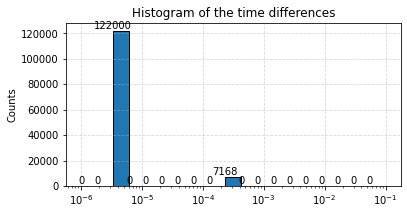

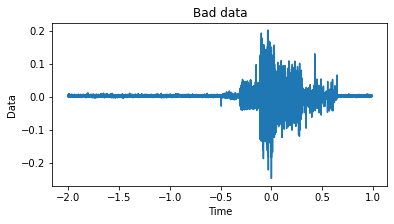

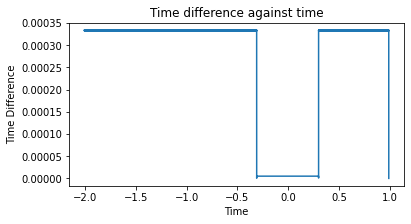

id: 111, t.shape: (129171,), d.shape: (129171,)


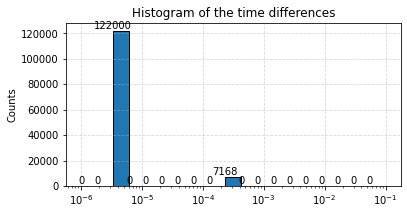

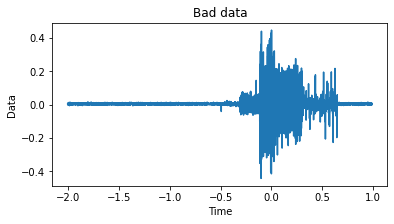

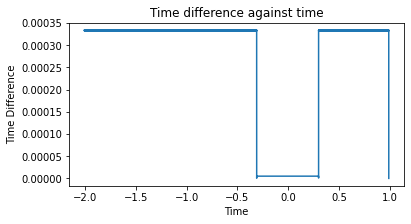

id: 136, t.shape: (199932,), d.shape: (199932,)


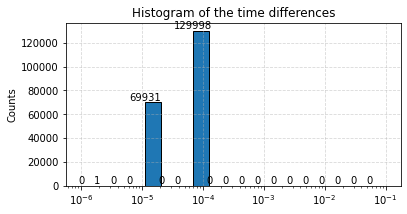

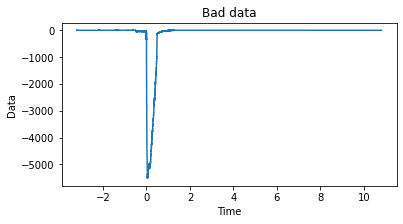

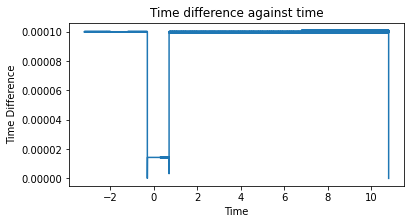

id: 156, t.shape: (207002,), d.shape: (207002,)


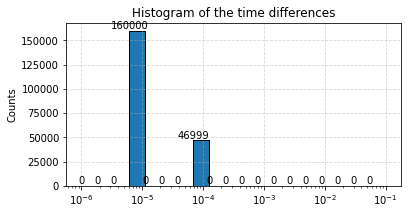

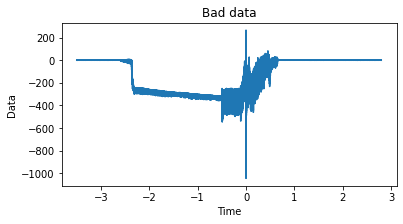

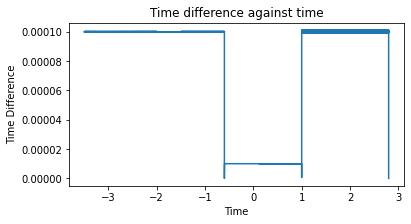

id: 171, t.shape: (194002,), d.shape: (194002,)


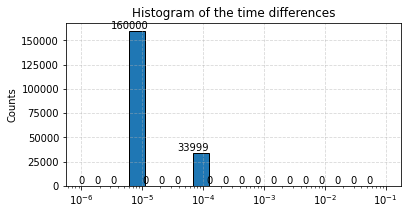

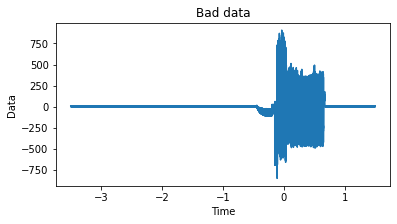

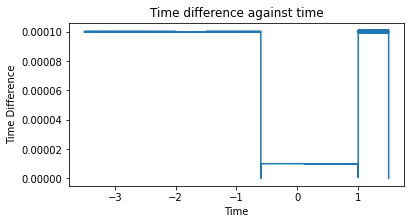

In [49]:
# pick bad times: high std of diff
# %matplotlib widget
%matplotlib inline
bad_times, bad_datas = [], []
for t, d, std in zip(times, datas, times_diff_stds):
    if std > 1e-6 and len(t)>100000: bad_times.append(t), bad_datas.append(d)
print(f'Found {len(bad_times)} bad times')
#select N random indices
N = 5
indices = np.random.choice(len(bad_times), N)
for i in indices:
    t,d = bad_times[i], bad_datas[i]
    print(f'id: {i}, t.shape: {t.shape}, d.shape: {d.shape}')
    diff = np.abs(np.diff(t)) # get the differences between the time vector, the deltas
    diff = np.append(diff, 0) # add
    #plot histogram if diff
    plt.figure(figsize=(6, 3))
    bins = np.logspace(-6, -1, 20)
    counts, bins, _ = plt.hist(diff, bins=bins, edgecolor='black')
    plt.ylabel('Counts')
    plt.title('Histogram of the time differences')
    plt.grid(True, linestyle='--', alpha=0.5)
    for i, count in enumerate(counts):
        plt.text(bins[i], count, str(int(count)), ha='center', va='bottom')
    plt.xscale('log')
    #plot the data vector
    plt.figure(figsize=(6, 3))
    plt.plot(t, d)
    plt.title('Strange data')
    plt.xlabel('Time')
    plt.ylabel('Data')
    # plot diff against t
    plt.figure(figsize=(6, 3))
    plt.plot(t, diff)
    plt.title('Time difference against time')
    plt.xlabel('Time')
    plt.ylabel('Time Difference')
    
    plt.show()